In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import dtreeviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

# Data Preparation

In [12]:
df = pd.read_csv("./data/nan_removed_cleaned_data.csv")
df.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'original_title', 'overview',
       'popularity', 'poster_path', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'log_popularity', 'title_length', 'num_languages', 'num_genres',
       'imdb_rating', 'imdb_budget', 'imdb_revenue', 'budget_currency',
       'revenue_currency', 'converted_budget', 'converted_revenue',
       'combined_budget', 'combined_revenue'],
      dtype='object')

Note: Python's sklearn decision trees functionality can only work with numeric data.

Looking at our columns above, the only non-numeric columns that *could* contribute to our decision trees are:
- genres
- spoken_languages
- release_date

It's not a huge deal if we disregard `genres` and `spoken_languages`, since we already have `num_genres` and `num_languages` respectively.

However, the `release_date` could prove very useful in our supervised learning. Let's convert this column to its unix timestamp equivalent:

In [13]:
# Convert our datetime objects to Unix timestamps
df['release_unix'] = pd.to_datetime(df['release_date'])
df['release_unix'] = df.release_unix.values.astype(np.int64) // 10 ** 9

# Select specific columns
df = df[['runtime', 'vote_count', 'log_popularity', 'title_length', 'num_languages',
          'num_genres', 'imdb_rating', 'combined_budget', 'combined_revenue', 'release_unix']]

# We only want data where we have an IMDB rating
df = df[df['imdb_rating'].notna()]

df.describe()

,runtime,vote_count,log_popularity,title_length,num_languages,num_genres,imdb_rating,combined_budget,combined_revenue,release_unix
count,13894.000000,13894.000000,13894.000000,13894.000000,13894.000000,13894.000000,13894.000000,1.389400e+04,1.389400e+04,1.389400e+04
mean,79.427235,411.985605,1.287343,16.518497,1.194185,1.886066,6.071002,7.712771e+06,1.784616e+07,7.786425e+08
std,39.160793,1570.239035,0.958684,9.578765,0.589630,1.022621,1.476596,2.201632e+07,8.054141e+07,1.592486e+09
min,0.000000,0.000000,0.470004,1.000000,1.000000,1.000000,1.100000,0.000000e+00,0.000000e+00,-9.223372e+09
25%,70.000000,1.000000,0.470004,10.000000,1.000000,1.000000,5.200000,4.000000e+04,0.000000e+00,8.172576e+08
50%,90.000000,6.000000,0.875469,14.000000,1.000000,2.000000,6.200000,5.000000e+05,0.000000e+00,1.199146e+09
75%,101.000000,79.000000,1.963013,20.000000,1.000000,3.000000,7.100000,4.000000e+06,2.499002e+05,1.394820e+09
max,540.000000,27894.000000,8.270913,112.000000,8.000000,8.000000,10.000000,4.050000e+08,2.147315e+09,1.678406e+09


Now we have our numeric data.

For most machine learning techniques (including this one), we need to separate our data into a training and testing set.

In [14]:
# Separate into train and test
train = df.sample(frac=0.8,random_state=1612)
test = df.drop(train.index)

Additionally, we need to assign labels to our data.

For this, we can use the IMDB ratings, putting them into bins.

Let's do 1-5.99 and 6-10 as bad(0) and good(1) respectively:

In [15]:
def num_ranking(entry):
    if entry['imdb_rating'] >= 6:
        return 1
    else:
        return 0

class_names = ['bad', 'good']

# Apply to train and test separately
train_labels = train.apply(num_ranking, axis=1)
test_labels = test.apply(num_ranking, axis=1)

# Now, drop the imdb_rating column from each
train = train.drop('imdb_rating', axis=1)
test = test.drop('imdb_rating', axis=1)

display(train_labels.value_counts())
test_labels.value_counts()

1    6502
0    4613
dtype: int64

1    1651
0    1128
dtype: int64

Perfect! Now we can apply a decision tree to this data.

# Decision Tree

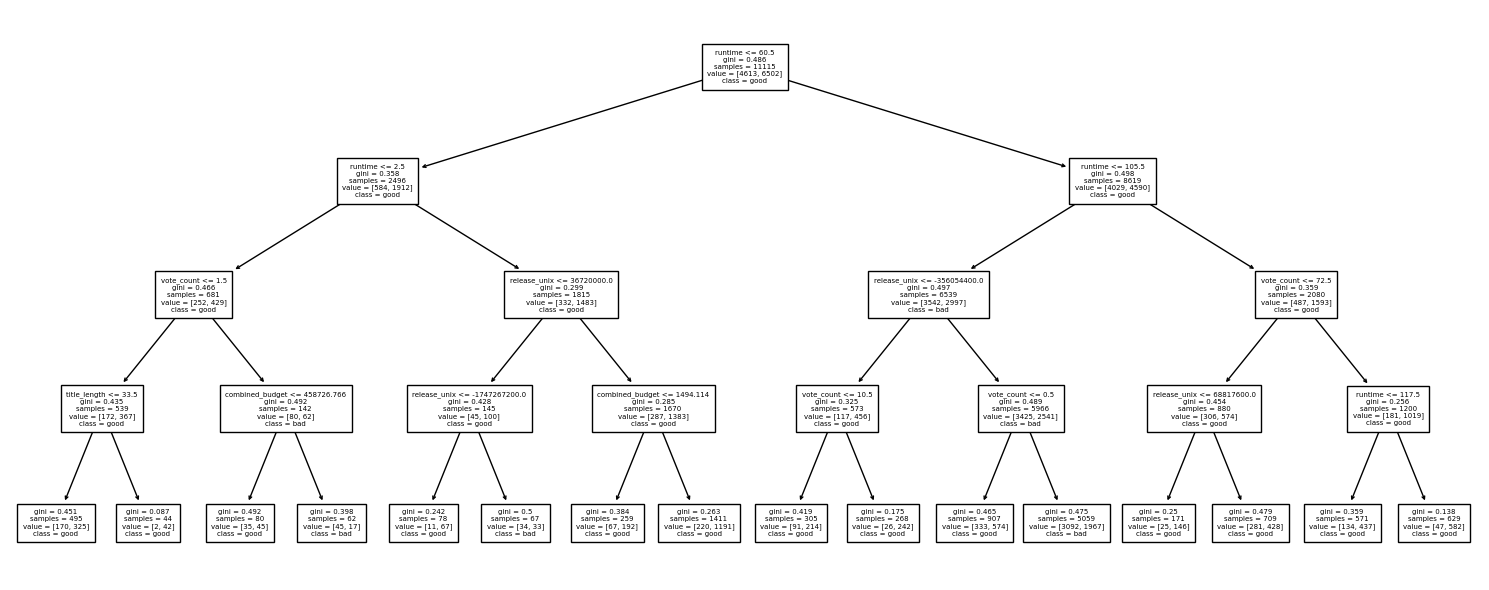

In [16]:
# Prepare the decision tree
film_DT = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=4,
                            min_samples_split=2,
                            random_state=None,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0)

# Fit to our training data
film_DT.fit(train, train_labels)
# Plot our tree
fig = plt.figure(figsize=(15, 6))
tree.plot_tree(film_DT,
               max_depth=None,
               feature_names=train.columns,
               class_names=class_names,
               fontsize=5)
fig.tight_layout()
plt.savefig('./imgs/dt_ims/tree_plot.png')

We can also visualize this tree based on distributions of values within each node:

In [17]:
viz = dtreeviz.model(film_DT, train, train_labels,
                target_name="target",
                feature_names=list(train.columns),
                class_names=class_names)

viszualization = viz.view().show()

C:\Users\Peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


And we can calculate metrics for our Decision Tree performance on the test set


The confusion matrix is:


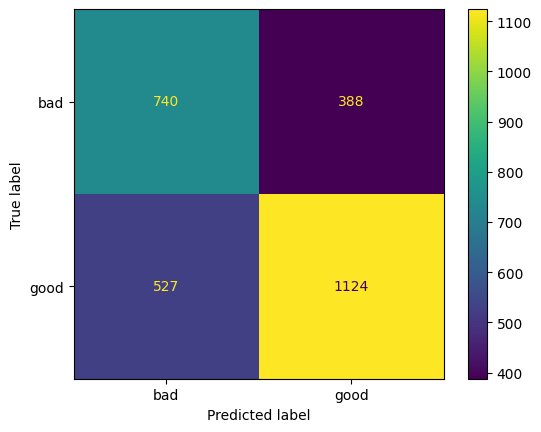

Metrics for Test Data
---------------------
Accuracy: 0.6707448722562073
Precision:
    ->bad: 0.5840568271507498
    ->good: 0.7433862433862434
Recall:
    ->bad: 0.6560283687943262
    ->good: 0.6807995154451847
F1 Score:
    ->bad: 0.6179540709812109
    ->good: 0.7107176730951629
Support:
    ->bad: 1128
    ->good: 1651

Important Features:
1. Feature runtime (0.6160903553221975)
2. Feature release_unix (0.1928014704755356)
3. Feature vote_count (0.171723134749567)
4. Feature combined_budget (0.011483644968251055)
5. Feature title_length (0.007901394484448878)


In [18]:
feature_names = train.columns
# Show the predictions from the DT on the test set
DT_pred = film_DT.predict(test)

# Show the confusion matrix
bn_matrix = confusion_matrix(test_labels, DT_pred)
print("\nThe confusion matrix is:")
disp = ConfusionMatrixDisplay(bn_matrix, display_labels=class_names)
disp.plot()
plt.savefig('./imgs/dt_ims/confusion_matrix.png')
plt.show()

# Print out metrics
print("Metrics for Test Data")
print("---------------------")
print(f"Accuracy: {accuracy_score(test_labels, DT_pred)}")

test_prec, test_recall, test_f1, test_support = precision_recall_fscore_support(test_labels, DT_pred)
print("Precision:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_prec[idx]}")

print("Recall:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_recall[idx]}")

print("F1 Score:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_f1[idx]}")

print("Support:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_support[idx]}")


FeatureImp = film_DT.feature_importances_   
indices = np.argsort(FeatureImp)[::-1]
# Print out the important features:
print("\nImportant Features:")
for f in range(train.shape[1]):
    if FeatureImp[indices[f]] > 0:
        print(f"{f+1}. Feature {feature_names[indices[f]]} ({FeatureImp[indices[f]]})")

We also want to show what happens when we don't limit the depth of our tree:

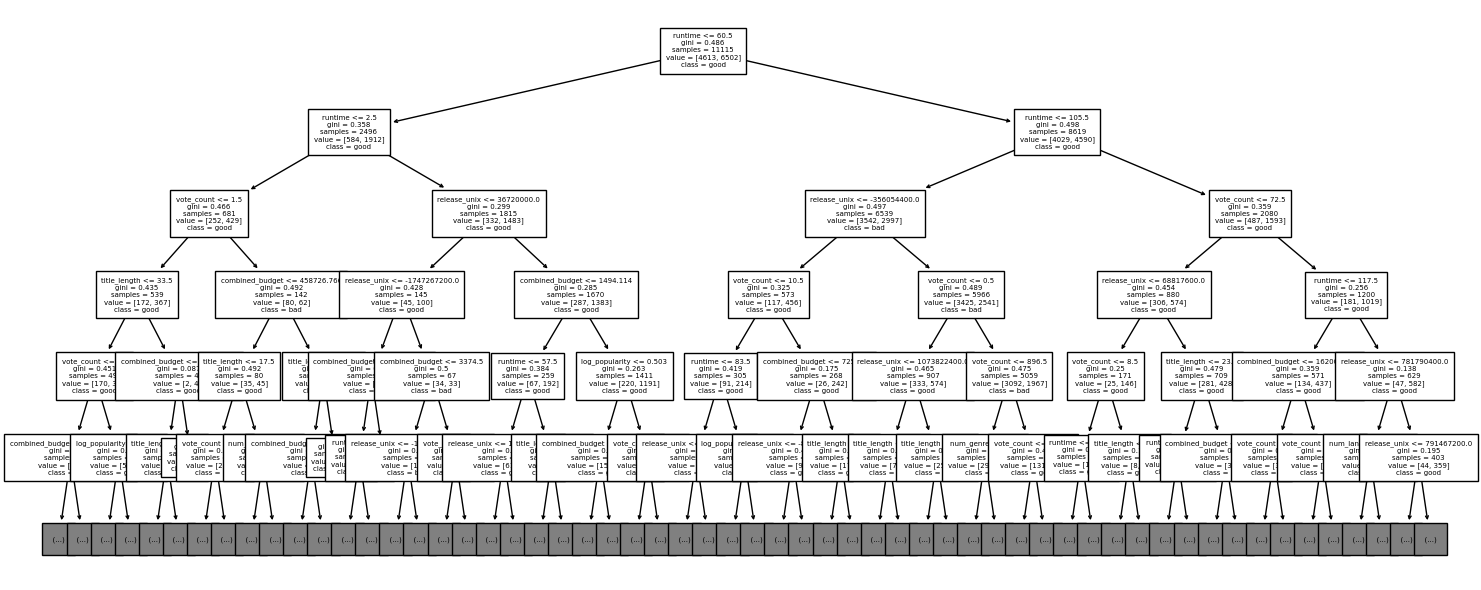

In [19]:
#Prepare the decision tree
film_DT_large = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            min_samples_split=2,
                            random_state=None,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0)

# Fit to our training data
film_DT_large.fit(train, train_labels)
# Plot our tree
fig = plt.figure(figsize=(15, 6))
tree.plot_tree(film_DT_large,
               max_depth=5,
               feature_names=train.columns,
               class_names=class_names,
               fontsize=5)
fig.tight_layout()
plt.savefig('./imgs/dt_ims/tree_plot_large.png')

In [26]:
print(f'The large, un-restricted decision tree has depth {film_DT_large.get_depth()}')

The large, un-restricted decision tree has depth 31


And show the metrics:


The confusion matrix is:


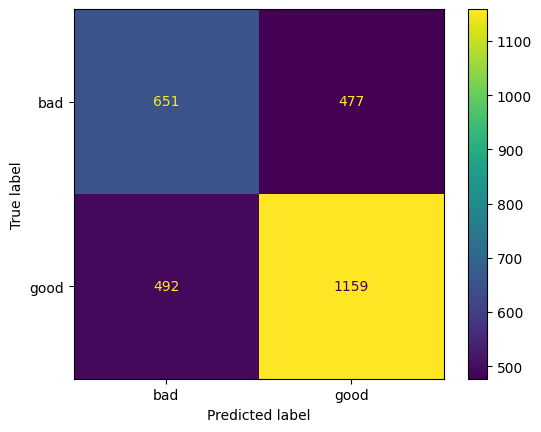

Metrics for Test Data (Large model)
---------------------
Accuracy: 0.6513134220942786
Precision:
    ->bad: 0.5695538057742782
    ->good: 0.7084352078239609
Recall:
    ->bad: 0.5771276595744681
    ->good: 0.7019987886129618
F1 Score:
    ->bad: 0.5733157199471598
    ->good: 0.7052023121387284
Support:
    ->bad: 1128
    ->good: 1651

Important Features:
1. Feature runtime (0.6160903553221975)
2. Feature release_unix (0.1928014704755356)
3. Feature vote_count (0.171723134749567)
4. Feature combined_budget (0.011483644968251055)
5. Feature title_length (0.007901394484448878)


In [20]:
feature_names = train.columns
# Show the predictions from the DT on the test set
DT_pred = film_DT_large.predict(test)

# Show the confusion matrix
bn_matrix = confusion_matrix(test_labels, DT_pred)
print("\nThe confusion matrix is:")
disp = ConfusionMatrixDisplay(bn_matrix, display_labels=class_names)
disp.plot()
plt.savefig('./imgs/dt_ims/confusion_matrix_large.png')
plt.show()

# Print out metrics
print("Metrics for Test Data (Large model)")
print("---------------------")
print(f"Accuracy: {accuracy_score(test_labels, DT_pred)}")

test_prec, test_recall, test_f1, test_support = precision_recall_fscore_support(test_labels, DT_pred)
print("Precision:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_prec[idx]}")

print("Recall:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_recall[idx]}")

print("F1 Score:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_f1[idx]}")

print("Support:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_support[idx]}")


FeatureImp = film_DT.feature_importances_   
indices = np.argsort(FeatureImp)[::-1]
# Print out the important features:
print("\nImportant Features:")
for f in range(train.shape[1]):
    if FeatureImp[indices[f]] > 0:
        print(f"{f+1}. Feature {feature_names[indices[f]]} ({FeatureImp[indices[f]]})")

Interestingly, this shows that making our tree better doesn't necessarily help our performance.

Next, let's construct a decision tree on our data, splitting the data into 3 categories instead of 2.

Let's do 1-3.99, 4-6.99, 7-10, as bad(0), average(1), good(2):

In [21]:
# We need to re-separate into train and test
train = df.sample(frac=0.8,random_state=1612)
test = df.drop(train.index)

def num_ranking(entry):
    if entry['imdb_rating'] >= 7:
        return 2
    elif entry['imdb_rating'] >= 4:
        return 1
    else:
        return 0

class_names = ['bad', 'average', 'good']

# Apply to train and test separately
train_labels = train.apply(num_ranking, axis=1)
test_labels = test.apply(num_ranking, axis=1)

# Now, drop the imdb_rating column from each
train = train.drop('imdb_rating', axis=1)
test = test.drop('imdb_rating', axis=1)

Now, construct the tree for this 3-class data:

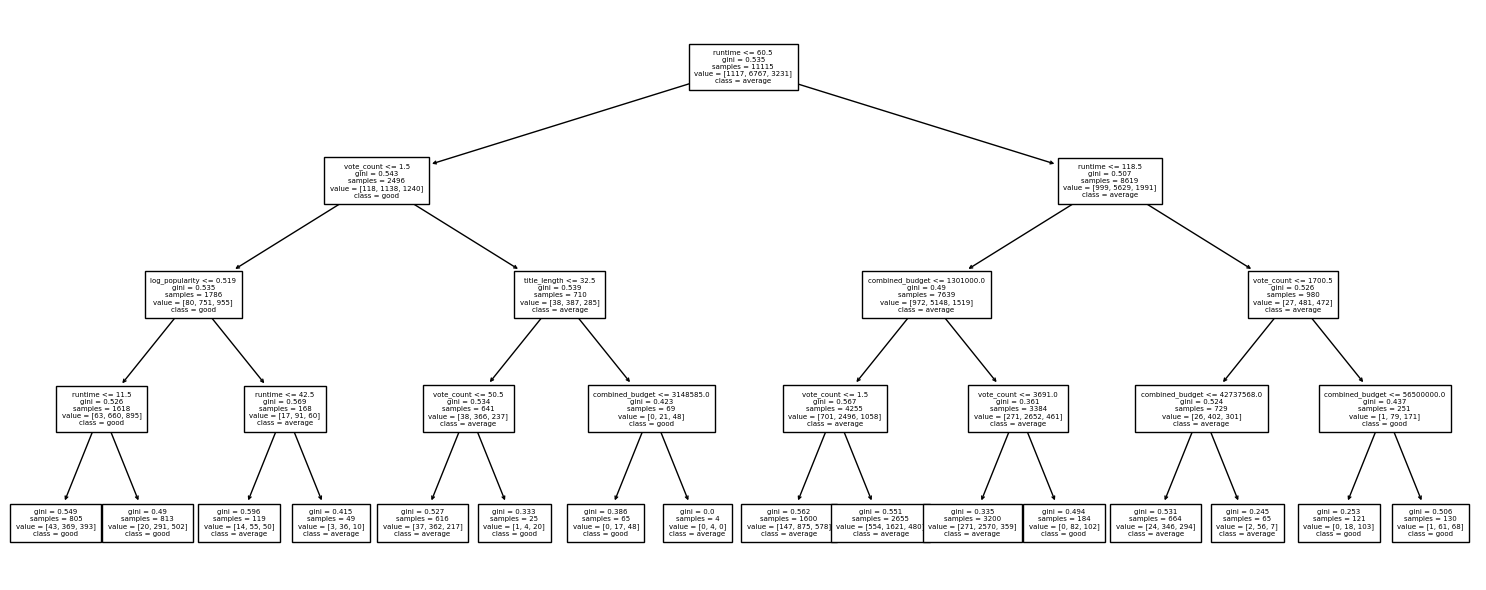

In [22]:
#Prepare the decision tree
film_DT_three = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            min_samples_split=2,
                            max_depth=4,
                            random_state=None,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0)

# Fit to our training data
film_DT_three.fit(train, train_labels)
# Plot our tree
fig = plt.figure(figsize=(15, 6))
tree.plot_tree(film_DT_three,
               max_depth=None,
               feature_names=train.columns,
               class_names=class_names,
               fontsize=5)
fig.tight_layout()
plt.savefig('./imgs/dt_ims/tree_plot_three.png')


The confusion matrix is:


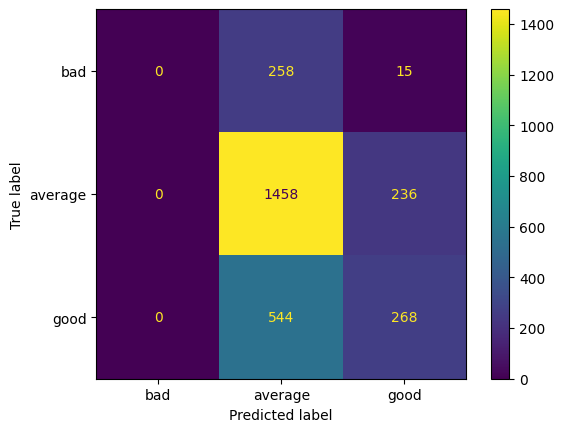

Metrics for Test Data (Three class)
---------------------
Accuracy: 0.6210867218423893
Precision:
    ->bad: 0.0
    ->average: 0.6451327433628319
    ->good: 0.5163776493256262
Recall:
    ->bad: 0.0
    ->average: 0.8606847697756789
    ->good: 0.33004926108374383
F1 Score:
    ->bad: 0.0
    ->average: 0.7374810318664644
    ->good: 0.4027047332832457
Support:
    ->bad: 273
    ->average: 1694
    ->good: 812

Important Features:
1. Feature runtime (0.6160903553221975)
2. Feature release_unix (0.1928014704755356)
3. Feature vote_count (0.171723134749567)
4. Feature combined_budget (0.011483644968251055)
5. Feature title_length (0.007901394484448878)


C:\Users\Peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [23]:
feature_names = train.columns
# Show the predictions from the DT on the test set
DT_pred = film_DT_three.predict(test)

# Show the confusion matrix
bn_matrix = confusion_matrix(test_labels, DT_pred)
print("\nThe confusion matrix is:")
disp = ConfusionMatrixDisplay(bn_matrix, display_labels=class_names)
disp.plot()
plt.savefig('./imgs/dt_ims/confusion_matrix_three.png')
plt.show()

# Print out metrics
print("Metrics for Test Data (Three class)")
print("---------------------")
print(f"Accuracy: {accuracy_score(test_labels, DT_pred)}")

test_prec, test_recall, test_f1, test_support = precision_recall_fscore_support(test_labels, DT_pred)
print("Precision:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_prec[idx]}")

print("Recall:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_recall[idx]}")

print("F1 Score:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_f1[idx]}")

print("Support:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_support[idx]}")


FeatureImp = film_DT.feature_importances_   
indices = np.argsort(FeatureImp)[::-1]
# Print out the important features:
print("\nImportant Features:")
for f in range(train.shape[1]):
    if FeatureImp[indices[f]] > 0:
        print(f"{f+1}. Feature {feature_names[indices[f]]} ({FeatureImp[indices[f]]})")

As we can see, we do a poor job predicting on the "bad" category when we extend this to 3 classes.